# 스팸 메일 분류하기(Spam Detection)  
https://wikidocs.net/22894  
딥 러닝을 이용한 자연어 처리 입문 - 유원준  



In [ ]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv", filename="spam.csv")
data = pd.read_csv('spam.csv',encoding='latin1')

In [ ]:
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 5572


In [ ]:
data[:5]
# ham은 정상 메일을 의미하고, spam은 스팸 메일

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
# Unnamed라는 이름의 3개의 열은 텍스트 분류를 할 때 불필요한 열
del data['Unnamed: 2']
del data['Unnamed: 3']
del data['Unnamed: 4']
# ham과 spam 레이블을 각각 숫자 0과 1로 바꾸겠습니다!!!!!!!!!
data['v1'] = data['v1'].replace(['ham','spam'],[0,1])
data[:5]

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
data.isnull().values.any()

False

In [ ]:
data['v2'].nunique(), data['v1'].nunique()
# 총 5,572개의 샘플이 존재하는데 v2열에서 중복을 제거한 샘플의 개수가 5,169개라는 것은 403개의 중복 샘플이 존재한다는 의미

(5169, 2)

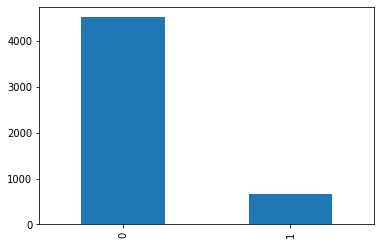

In [ ]:
data.drop_duplicates(subset=['v2'], inplace=True)
data['v1'].value_counts().plot(kind='bar');

In [ ]:
# 레이블이 대부분 0에 편중되어있는데, 이는 스팸 메일 데이터의 대부분의 메일이 정상 메일임을 의미
print(data.groupby('v1').size().reset_index(name='count'))

   v1  count
0   0   4516
1   1    653


In [ ]:
# 이제 X와 y를 분리합니다. v2열을 X, v1열을 y로 저장   
X_data = data['v2']
y_data = data['v1']
print('메일 본문의 개수: {}'.format(len(X_data)))
print('레이블의 개수: {}'.format(len(y_data)))

메일 본문의 개수: 5169
레이블의 개수: 5169


In [ ]:
# 케라스 토크나이저를 통해 토큰화와 정수 인코딩 과정을 수행해보겠습니다.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_data) # 5169개의 행을 가진 X의 각 행에 토큰화를 수행
sequences = tokenizer.texts_to_sequences(X_data) # 단어를 숫자값, 인덱스로 변환하여 저장
# sequences에는 X_data의 단어들이 각 단어에 맵핑되는 정수로 인코딩되어 저장되었습니다. 
word_to_index = tokenizer.word_index
print(word_to_index)
# 각 단어의 빈도수가 높을 수록 낮은 정수가 부여

[[47, 433, 4013, 780, 705, 662, 64, 8, 1202, 94, 121, 434, 1203, 142, 2712, 1204, 68, 57, 4014, 137], [49, 306, 1364, 435, 6, 1767], [53, 537, 8, 20, 4, 1016, 934, 2, 220, 2713, 1365, 706, 2714, 2715, 267, 2716, 70, 2713, 2, 2717, 2, 359, 537, 604, 1205, 82, 436, 185, 707, 437, 4015], [6, 226, 152, 23, 347, 2718, 6, 138, 145, 56, 152], [935, 1, 97, 96, 69, 453, 2, 877, 69, 1768, 198, 105, 438]]


In [ ]:
# 등장 빈도수가 1회 밖에 되지 않는 단어들이 전체 단어 집합에서 얼만큼의 비율을 차지하며,   
# 전체 훈련 데이터에서 등장 빈도로 얼만큼의 비율을 차지하는지 확인  
threshold = 2
total_cnt = len(word_to_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

등장 빈도가 1번 이하인 희귀 단어의 수: 4908
단어 집합(vocabulary)에서 희귀 단어의 비율: 55.02242152466368
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.082538108811501


등장 빈도가 __threshold__ 값인 2회 미만. 즉, 1회 밖에 되지 않는 단어들은 단어 집합에서 무려 절반 이상을 차지합니다.   
하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 6%밖에 되지 않습니다. 

In [ ]:
# 집합의 크기를 vocab_size에 저장하겠습니다  
# 주의할 점은 패딩을 위한 토큰인 0번 단어를 고려하며 +1을 해서 저장해주어야 한다는 점
vocab_size = len(word_to_index) + 1
print('단어 집합의 크기: {}'.format((vocab_size)))

단어 집합의 크기: 8921


In [ ]:
n_of_train = int(len(sequences) * 0.8)
n_of_test = int(len(sequences) - n_of_train)
print('훈련 데이터의 개수 :',n_of_train)
print('테스트 데이터의 개수:',n_of_test)

훈련 데이터의 개수 : 4135
테스트 데이터의 개수: 1034


메일의 최대 길이 : 189
메일의 평균 길이 : 15.610370


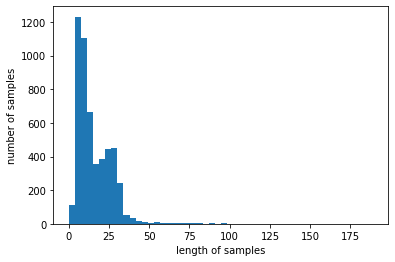

In [ ]:
# 정수 인코딩 된 결과인 sequences를 X_data로 변경하고    
# 전체 데이터에서 가장 길이가 긴 메일과 전체 메일 데이터의 길이 분포를 알아보도록 하겠습니다.
X_data = sequences
print('메일의 최대 길이 : %d' % max(len(l) for l in X_data))
print('메일의 평균 길이 : %f' % (sum(map(len, X_data))/len(X_data)))
plt.hist([len(s) for s in X_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
max_len = 189
# 전체 데이터셋의 길이는 max_len으로 맞춥니다.
data = pad_sequences(X_data, maxlen = max_len)
print("훈련 데이터의 크기(shape): ", data.shape)

훈련 데이터의 크기(shape):  (5169, 189)


In [ ]:
X_test = data[n_of_train:] #X_data 데이터 중에서 뒤의 1034개의 데이터만 저장
y_test = np.array(y_data[n_of_train:]) #y_data 데이터 중에서 뒤의 1034개의 데이터만 저장
X_train = data[:n_of_train] #X_data 데이터 중에서 앞의 4135개의 데이터만 저장
y_train = np.array(y_data[:n_of_train]) #y_data 데이터 중에서 앞의 4135개의 데이터만 저장

# RNN으로 스팸 메일 분류하기

In [ ]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 32)) # 임베딩 벡터의 차원은 32
model.add(SimpleRNN(32)) # RNN 셀의 hidden_size는 32
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=4, batch_size=64, validation_split=0.2)

Epoch 1/4
52/52 [==============================] - 3s 48ms/step - loss: 0.3070 - acc: 0.9024 - val_loss: 0.1501 - val_acc: 0.9686
Epoch 2/4
52/52 [==============================] - 2s 43ms/step - loss: 0.1097 - acc: 0.9719 - val_loss: 0.0898 - val_acc: 0.9722
Epoch 3/4
52/52 [==============================] - 2s 40ms/step - loss: 0.0590 - acc: 0.9861 - val_loss: 0.0635 - val_acc: 0.9794
Epoch 4/4
52/52 [==============================] - 2s 44ms/step - loss: 0.0391 - acc: 0.9897 - val_loss: 0.0657 - val_acc: 0.9843


Embedding()은 두 개의 인자를 받습니다.  
단어 집합의 크기, 임베딩 벡터의 차원입니다.  
이진 분류 문제 이므로 마지막 출력층에는 1개의 뉴런과 활성화 함수로 시그모이드 함수를 사용합니다.  
손실 함수로는 binary_crossentropy를 사용합니다.

In [ ]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

33/33 [==============================] - 0s 9ms/step - loss: 0.0683 - acc: 0.9807

 테스트 정확도: 0.9807
